In [4]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[]

In [20]:
POS_PATH = os.path.join('data','poistive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [7]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

NameError: name 'POS_PATH' is not defined

In [ ]:
for direct in os.listdir('lfw-deepfunneled'):
    for file in os.listdir(os.path.join('lfw-deepfunneled',direct)):
        EX_PATH = os.path.join('lfw-deepfunneled',direct,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [ ]:
for file in os.listdir(os.path.join('data','images')):
    EX_PATH = os.path.join('data','images',file)
    NEW_PATH = os.path.join(NEG_PATH,file)
    os.replace(EX_PATH,NEW_PATH)

In [ ]:
for x in os.listdir('archive (1)'):
    for direct in os.listdir(os.path.join('archive (1)',x)):
        for file in os.listdir(os.path.join('archive (1)',x,direct)):
            EX_PATH = os.path.join('archive (1)',x,direct,file)
            NEW_PATH = os.path.join(NEG_PATH,file)
            os.replace(EX_PATH,NEW_PATH)

In [11]:
import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[120:120+250,120:120+250,:]
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

In [13]:
def data_aug(img):
    data = []
    for i in range (9):
        img = tf.image.stateless_random_brightness(img,max_delta=0.02,seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
        data.append(img)
    return data

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [17]:
img_path = os.path.join(ANC_PATH, 'a91db690-028b-11f0-8c2f-58fb8442ae13.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img) 
    
for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [22]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\\*.jpg').take(3000)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [11]:
dir_test.next()

b'data\\anchor\\a033024d-028b-11f0-af93-58fb8442ae13.jpg'

In [24]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img= img[:, :, :3]
    img = img/255.0
    return img

In [15]:
img = preprocess('data\\anchor\\9e05b992-028b-11f0-b8d8-58fb8442ae13.jpg')

In [17]:
img.numpy().max()

0.7151961

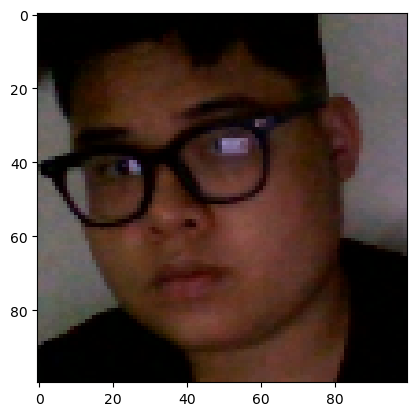

In [19]:
plt.imshow(img)

In [217]:
#Gan nhan
#(anchor,positive) =>1,1,1,1
#(anchor,negative) =>0,0,0,0

In [26]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
samples = data.as_numpy_iterator()

In [25]:
example = samples.next()

In [27]:
example

(b'data\\anchor\\e8229de1-0806-11f0-a2cd-58fb8442ae13.jpg',
 b'data\\poistive\\d929ee80-0806-11f0-83c4-58fb8442ae13.jpg',
 1.0)

In [28]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [31]:
res = preprocess_twin(*example)

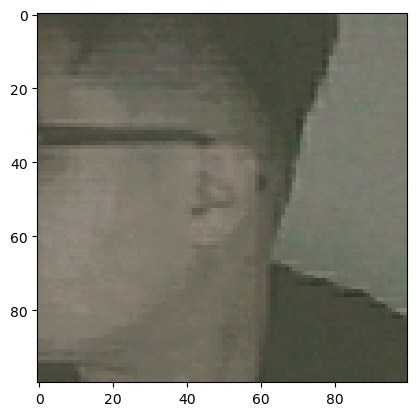

In [33]:
plt.imshow(res[1])

In [35]:
res[2]

1.0

In [30]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 10000)

In [191]:
data
round(len(data))

538

In [215]:
round(int(0.7 * data.cardinality().numpy()))

376

In [201]:
train_size = int(0.7 * data.cardinality().numpy())
train_data =data.take(train_size).batch(16).prefetch(8)
test_data = data.skip(train_size).batch(16).prefetch(8)

In [205]:
round(len(test_data))

11

In [47]:
train_samples = train_data.as_numpy_iterator()

In [49]:
train_sample = train_samples.next()

In [207]:
test_samples = test_data.as_numpy_iterator()

In [211]:
test_sample=test_samples.next()

In [213]:
len(test_sample[0])

16

In [173]:
len(train_sample[0])

16

In [53]:
inp = Input(shape=(100,100,3),name = 'input_image')

In [40]:
def make_embedding():
    inp = Input(shape=(100,100,3),name = 'input_image')
    c1 = Conv2D(64,(10,10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    c2 = Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)
    c3 = Conv2D(128,(4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)
    c4 = Conv2D(256,(4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation = 'sigmoid')(f1)

    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [42]:
embedding = make_embedding()

In [32]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs([a - b for a, b in zip(input_embedding, validation_embedding)])

In [34]:
input_image = Input(name='input_img' , shape=(100,100,3))
validation_image = Input(name='validation_img' , shape=(100,100,3))

In [36]:
input_image

<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=False, ragged=False, name=input_img>

In [44]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [46]:
inp_embedding

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_9>]

In [48]:
siamese_layer = L1Dist()

In [50]:
import tensorflow.compat.v1
tf.compat.v1.disable_v2_behavior 

<function tensorflow.python.compat.v2_compat.disable_v2_behavior()>

In [52]:
distances = siamese_layer(inp_embedding,val_embedding)

In [54]:
print(distances.shape)

(1, None, 4096)


In [56]:
class SqueezeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.squeeze(inputs, axis=0)

distances = SqueezeLayer()(distances)

In [77]:
print(distances.shape)

(None, 4096)


In [58]:
classifier = Dense(1,activation = 'sigmoid')(distances)

In [60]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_13>

In [62]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [64]:
def make_siamese_model(): 
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Tính khoảng cách L1 giữa hai embeddings
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Thay thế Lambda layer bằng Custom Layer
    distances = SqueezeLayer()(distances)

    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [66]:
siamese_model = make_siamese_model()

In [68]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (1, None, 4096)           │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ squeeze_layer_2               │ (None, 4096)              │               0 │ l1_dist_1[0][0]            │
│ (SqueezeLayer)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           4,097 │ squeeze_layer_2[0][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [72]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [113]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [115]:
test_batch = train_data.as_numpy_iterator()

In [127]:
batch_1 = test_batch.next()

In [319]:
X =batch_1[:2] 

In [321]:
y= batch_1[2]

In [ ]:
X

In [325]:
y

array([0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.],
      dtype=float32)

In [ ]:
tf.losses.BinaryCrossentropy??

In [221]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X =batch_1[:2] 
        y = batch_1[2]
        yhat = siamese_model(X,training = True)
        loss = binary_cross_loss(y,yhat)
    print(loss)
    grad = tape.gradient (loss,siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

In [131]:
from tensorflow.keras.metrics import Precision,Recall

In [133]:
def train(data,EPOCHES):
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        r = Recall()
        p = Precision()
        for idx,batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2],yhat)
            p.update_state(batch[2],yhat)
            progbar.update(idx+1)
        print(loss.numpy(),r.result().numpy(),p.result().numpy())
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [135]:
EPOCHS = 40

In [ ]:
train(train_data,EPOCHS)

In [139]:
siamese_model.save('face_recognition_siamese.keras')

In [141]:
L1Dist

__main__.L1Dist

In [74]:
siamese_model = tf.keras.models.load_model(
    'face_recognition_siamese.keras',
    custom_objects={'L1Dist': L1Dist, 'binary_cross_loss': binary_cross_loss, 'SqueezeLayer': SqueezeLayer}
)


In [217]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [223]:

y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [225]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]

In [227]:

y_true

array([1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
      dtype=float32)

In [241]:

r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Recall: 0.9432
Precision:0.8218


In [243]:
print(f"Recall: {r.result().numpy():.4f}")
print (f"Precision:{ p.result().numpy():.4f}")

Recall: 0.9432
Precision:0.8218


In [255]:
print(f"F1-score: {f1:.4f}")

F1-score: 0.8783


In [257]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_3 (L1Dist)            │ (1, None, 4096)           │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ squeeze_layer_1               │ (None, 4096)              │               0 │ l1_dist_3[0][0]            │
│ (SqueezeLayer)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           4,097 │ squeeze_layer_1[0][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
application_data\verification_images

In [ ]:
os.listdir(os.path.join('application_data','verification_images'))

In [267]:
os.path.join('application_data','input_images','input_images.jpg')

'application_data\\input_images\\input_images.jpg'

In [76]:

for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\04bfdd42-028c-11f0-ac2f-58fb8442ae13.jpg
application_data\verification_images\04f742a3-028c-11f0-b92d-58fb8442ae13.jpg
application_data\verification_images\05fbb137-028c-11f0-8726-58fb8442ae13.jpg
application_data\verification_images\06b3615d-028c-11f0-a13f-58fb8442ae13.jpg
application_data\verification_images\06bf670e-028c-11f0-9a2f-58fb8442ae13.jpg
application_data\verification_images\07bb8f37-028c-11f0-b341-58fb8442ae13.jpg
application_data\verification_images\07ceeb5e-028c-11f0-b2bf-58fb8442ae13.jpg
application_data\verification_images\0a30a08d-028c-11f0-b6b4-58fb8442ae13.jpg
application_data\verification_images\0a72274e-028c-11f0-9b02-58fb8442ae13.jpg
application_data\verification_images\0aae4576-028c-11f0-90b3-58fb8442ae13.jpg
application_data\verification_images\0b8ab60a-028c-11f0-bbb2-58fb8442ae13.jpg
application_data\verification_images\0ba57f1e-028c-11f0-b3ba-58fb8442ae13.jpg
application_data\verification_images\0baeee2b-028c-11f0-a0fc-58f

In [105]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_images.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)),verbose=0)
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [107]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_images.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
False
False
